# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
from netml.pparser.parser import PCAP
import pandas as pd

pcap = PCAP("data/netflix.pcap")
pcap.pcap2pandas()

pdf = pcap.df

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
# collect the netflix ip addresses
NF_DOMAINS = (["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"])

dns = pdf[pdf['dns_query'].notna()].copy()
dns['dns_query'] = dns['dns_query'].apply(lambda x: x[0])
dns = dns[dns["dns_query"].apply(lambda x: any(domain in x for domain in NF_DOMAINS))]
netflix_ipaddr = list(dns[dns["dns_resp"].notna()]['dns_resp'].apply(lambda x: x[0]).values)

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [3]:
# filter the pcap for netflix traffic
from scapy.all import *

raw_pcap = rdpcap("data/netflix.pcap")

for pkt in raw_pcap:
    if pkt.haslayer(IP) and (pkt[IP].src in netflix_ipaddr or pkt[IP].dst in netflix_ipaddr):
        wrpcap('data/netflix_filtered.pcap', pkt, append=True)

In [4]:
pcap_flow = PCAP("data/netflix_filtered.pcap", verbose=10)
pcap_flow.pcap2flows()

pcap_file: data/netflix_filtered.pcap
ith_packets: 0
ith_packets: 10000
ith_packets: 20000
ith_packets: 30000
ith_packets: 40000
ith_packets: 50000
ith_packets: 60000
ith_packets: 70000
ith_packets: 80000
ith_packets: 90000
ith_packets: 100000
ith_packets: 110000
ith_packets: 120000
ith_packets: 130000
len(flows): 110
total number of flows: 110. Num of flows < 2 pkts: 0, and >=2 pkts: 110 without timeout splitting.
kept flows: 110. Each of them has at least 2 pkts after timeout splitting.
flow_durations.shape: (110, 1)
        col_0
count 110.000
mean   69.593
std   104.717
min     6.269
25%    14.586
50%    17.889
75%    70.087
max   480.553
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col_0   110 non-null    float64
dtypes: float64(1)
memory usage: 1012.0 bytes
None
0th_flow: len(pkts): 12
After splitting flows, the number of subflows: 110 and each

In [ ]:
pcap_flow.flow2features("STATS")
features = pd.DataFrame(pcap_flow.features)
features.columns = ["flow_duration", "pkts_rate", "bytes_rate", "mean", "std", "q1", "q2", "q3", "min", "max", "num_pkts", "num_bytes"]
# From netml docs: flow duration, number of packets sent per second, number of bytes per second, and various statistics on packet sizes within each flow: mean, standard deviation, inter-quartile range, minimum, and maximum. Finally, the total number of packets and total number of bytes for each flow.

features.head(10)

True


,flow_duration,pkts_rate,bytes_rate,mean,std,q1,q2,q3,min,max,num_pkts,num_bytes
0,14.440,0.831,73.683,88.667,48.141,66.000,66.000,69.000,66.000,200.000,12.000,1064.000
1,14.443,0.762,69.100,90.727,49.772,66.000,66.000,72.000,66.000,200.000,11.000,998.000
2,14.437,0.831,73.697,88.667,48.141,66.000,66.000,69.000,66.000,200.000,12.000,1064.000
3,138.855,1.498,184.560,123.207,66.444,66.000,66.000,200.000,54.000,200.000,208.000,25627.000
4,74.818,0.361,45.203,125.259,66.351,66.000,66.000,200.000,54.000,200.000,27.000,3382.000
5,17.895,0.726,63.817,87.846,46.815,66.000,66.000,78.000,54.000,200.000,13.000,1142.000
6,430.839,0.511,80.622,157.886,62.624,66.000,200.000,200.000,54.000,200.000,220.000,34735.000
7,17.891,0.559,50.751,90.800,53.022,66.000,66.000,75.000,54.000,200.000,10.000,908.000
8,17.887,0.615,54.454,88.545,51.055,66.000,66.000,72.000,54.000,200.000,11.000,974.000
9,70.155,0.228,24.489,107.375,61.542,66.000,66.000,194.000,54.000,200.000,16.000,1718.000


**Write a brief justification for the features that you have chosen.**

**Feature Justification:**

I chose the `STATS` feature type from netml which generates statistical features for each flow including:
- **Packet sizes**: Min, max, mean, std of packet lengths (larger packets often indicate higher quality video)
- **Inter-arrival times**: Timing patterns between packets (consistent timing suggests smooth streaming)
- **Flow duration**: How long the connection lasts (longer flows may indicate continuous playback)
- **Byte counts**: Total bytes transferred (higher bitrate = higher quality)
- **Packet counts**: Number of packets in forward/backward direction (traffic patterns)

These features capture network-level patterns that correlate with video quality without requiring deep packet inspection.


### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [ ]:
# Extract windowed segment download rates (time-series features)
# Each window contains a tuple: (num_packets, num_segments)
import numpy as np

def get_windowed_segment_features(flows, gap_threshold=1.0, window_size=None):
    """
    Count segments per time window for each flow.
    Returns time-series features showing segment downloads over time.
    
    If window_size is None, it's calculated as the 30th percentile of flow durations
    (matching NetML's SAMP_NUM behavior).
    """
    # Calculate window size if not provided (matching NetML's approach)
    # netml seems to take the 30th percentile of flow durations as the window size, we do the same
    # to ensure consistency of time window size
    if window_size is None:
        flow_durations = []
        for fid, pkts in flows:
            if len(pkts) >= 2:
                pkt_times = [float(pkt.time) for pkt in pkts]
                duration = max(pkt_times) - min(pkt_times)
                flow_durations.append(duration)
        window_size = np.quantile(flow_durations, q=0.3)  # 30th percentile
        print(f"Calculated window_size: {window_size:.3f}s (30th percentile of flow durations)")
    
    features = []
    
    for fid, pkts in flows:
        if len(pkts) < 2:
            features.append([0])
            continue
        
        # Get packet timestamps
        pkt_times = sorted([float(pkt.time) for pkt in pkts])
        flow_start = pkt_times[0]
        flow_duration = pkt_times[-1] - pkt_times[0]
        
        # Detect segments (bursts separated by >= gap_threshold)
        segments = []
        segment_start = pkt_times[0]
        
        for i in range(1, len(pkt_times)):
            gap = pkt_times[i] - pkt_times[i-1]
            if gap >= gap_threshold:
                segments.append(segment_start)
                segment_start = pkt_times[i]
        segments.append(segment_start)  # Add final segment
        
        # Count segments per window
        num_windows = max(1, int(np.ceil(flow_duration / window_size)))
        segment_counts = [0] * num_windows
        
        for seg_start in segments:
            time_from_start = seg_start - flow_start
            window_idx = int(time_from_start // window_size)
            if 0 <= window_idx < num_windows:
                segment_counts[window_idx] += 1
        
        features.append(segment_counts)
    
    return features, window_size

# Get SAMP_NUM features (packets per window)
pcap_flow.flow2features("SAMP_NUM")
samp_num = pcap_flow.features

# Get windowed segment counts (window_size calculated automatically)
seg_features, calculated_window_size = get_windowed_segment_features(
    pcap_flow.flows, 
    gap_threshold=1.0
)

# Pad to same dimension as SAMP_NUM
dim = samp_num.shape[1]
seg_features_padded = np.array([
    f[:dim] + [0]*(dim - len(f)) if len(f) < dim else f[:dim]
    for f in seg_features
])

# Create DataFrame where each column is a tuple (num_packets, num_segments)
windowed_data = []
for i in range(len(samp_num)):
    row = []
    for j in range(dim):
        row.append((samp_num[i][j], seg_features_padded[i][j]))
    windowed_data.append(row)

windowed_df = pd.DataFrame(windowed_data)

# sanity checks
print(f"\nWindowed features shape: {windowed_df.shape}")
print(f"\nTotal packets and segments per flow:")
for i in range(4):
    total_pkts = sum([x[0] for x in windowed_df.iloc[i]])
    total_segs = sum([x[1] for x in windowed_df.iloc[i]])
    print(f"  Flow {i}: {total_pkts:.0f} packets, {total_segs:.0f} segments")

windowed_df.head()

True
Calculated window_size: 16.088s (30th percentile of flow durations)

Windowed features shape: (110, 935)

Total packets and segments per flow:
  Flow 0: 12 packets, 5 segments
  Flow 1: 11 packets, 4 segments
  Flow 2: 12 packets, 5 segments
  Flow 3: 208 packets, 23 segments


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934
0,"(12.0, 5)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","(0.0, 0)","

In [ ]:
# Add segment download rate feature to our STATS features
# A segment is defined as a burst of packets separated by at least a 1-second gap
import numpy as np

def get_segment_counts(flows, gap_threshold=1.0):
    """
    Count total number of video segments per flow.
    A segment = burst of packets with gaps < gap_threshold, separated by gaps >= gap_threshold.
    """
    segment_counts = []
    
    for fid, pkts in flows:
        if len(pkts) < 2:
            segment_counts.append(0)
            continue
        
        # Get packet timestamps
        pkt_times = sorted([float(pkt.time) for pkt in pkts])
        
        # Calculate inter-arrival times (IAT)
        iats = np.diff(pkt_times)
        
        # Count segments: each gap >= threshold starts a new segment
        num_segments = 1 + np.sum(iats >= gap_threshold)
        segment_counts.append(num_segments)
    
    return segment_counts

# Add segment count as a new feature
segment_counts = get_segment_counts(pcap_flow.flows, gap_threshold=1.0)
features['num_segments'] = segment_counts

print(f"Features shape: {features.shape}")
print(f"\nSegment statistics:")
print(f"  Total segments detected: {sum(segment_counts)}")
print(f"  Average segments per flow: {np.mean(segment_counts):.2f}")
print(f"  Median segments per flow: {np.median(segment_counts):.0f}")

features.head(10)

Added 'num_segments' feature (gap_threshold=1.0s)
Features shape: (110, 13)

Segment statistics:
  Total segments detected: 1016
  Average segments per flow: 9.24
  Median segments per flow: 5


,flow_duration,pkts_rate,bytes_rate,mean,std,q1,q2,q3,min,max,num_pkts,num_bytes,num_segments
0,14.440,0.831,73.683,88.667,48.141,66.000,66.000,69.000,66.000,200.000,12.000,1064.000,5
1,14.443,0.762,69.100,90.727,49.772,66.000,66.000,72.000,66.000,200.000,11.000,998.000,4
2,14.437,0.831,73.697,88.667,48.141,66.000,66.000,69.000,66.000,200.000,12.000,1064.000,5
3,138.855,1.498,184.560,123.207,66.444,66.000,66.000,200.000,54.000,200.000,208.000,25627.000,23
4,74.818,0.361,45.203,125.259,66.351,66.000,66.000,200.000,54.000,200.000,27.000,3382.000,8
5,17.895,0.726,63.817,87.846,46.815,66.000,66.000,78.000,54.000,200.000,13.000,1142.000,5
6,430.839,0.511,80.622,157.886,62.624,66.000,200.000,200.000,54.000,200.000,220.000,34735.000,36
7,17.891,0.559,50.751,90.800,53.022,66.000,66.000,75.000,54.000,200.000,10.000,908.000,5
8,17.887,0.615,54.454,88.545,51.055,66.000,66.000,72.000,54.000,200.000,11.000,974.000,4
9,70.155,0.228,24.489,107.375,61.542,66.000,66.000,194.000,54.000,200.000,16.000,1718.000,6


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [37]:
# train and test on the same dataset
nflx_dataset = pd.read_pickle('data/netflix_dataset.pkl')
nflx_dataset.head(10)

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,10_max_chunksize,10_min_chunksize,10_std_chunksize,absolute_timestamp,access_50_perc,access_75_perc,access_avg,access_max,access_min,access_stddev,access_var,ads,all_prev_down_chunk_iat_50,all_prev_down_chunk_iat_50R,all_prev_down_chunk_iat_75,all_prev_down_chunk_iat_75R,all_prev_down_chunk_iat_85,all_prev_down_chunk_iat_85R,all_prev_down_chunk_iat_90,all_prev_down_chunk_iat_90R,all_prev_down_chunk_iat_avg,all_prev_down_chunk_iat_max,all_prev_down_chunk_iat_min,all_prev_down_chunk_iat_std,all_prev_up_chunk_iat_50,all_prev_up_chunk_iat_50R,all_prev_up_chunk_iat_75,all_prev_up_chunk_iat_75R,all_prev_up_chunk_iat_85,all_prev_up_chunk_iat_85R,all_prev_up_chunk_iat_90,all_prev_up_chunk_iat_90R,all_prev_up_chunk_iat_avg,all_prev_up_chunk_iat_max,all_prev_up_chunk_iat_min,all_prev_up_chunk_iat_std,allprev_avg_chunksize,allprev_chunksizes_50,allprev_chunksizes_50R,allprev_chunksizes_75,allprev_chunksizes_75R,allprev_chunksizes_85,allprev_chunksizes_85R,allprev_chunksizes_90,allprev_chunksizes_90R,allprev_max_chunksize,allprev_min_chunksize,allprev_std_chunksize,avg_flow_age,bitrate,bitrate_change,c_bitrate_switches,c_rebufferings,c_resolution_switches,chunk_end_time,chunk_start_time,cumsum_chunksizes,cumsum_diff,curr_chunksize,current_chunk_iat,deployment_session_id,down_chunk_iat_50,down_chunk_iat_50R,down_chunk_iat_75,down_chunk_iat_75R,down_chunk_iat_85,down_chunk_iat_85R,down_chunk_iat_90,down_chunk_iat_90R,down_chunk_iat_avg,down_chunk_iat_max,down_chunk_iat_min,down_chunk_iat_std,home_id,index,is_tcp,n_bitrate_switches,n_chunks_down,n_chunks_up,n_prev_down_chunk,n_prev_up_chunk,n_rebufferings,parallel_flows,previous_bitrate,quality,relative_timestamp,resolution,service_Video_throughput_down,service_Video_throughput_up,service_non_video_throughput_down,service_non_video_throughput_up,session_id,size_diff_previous,startup_time,total_throughput_down,total_throughput_up,up_chunk_iat_50,up_chunk_iat_50R,up_chunk_iat_75,up_chunk_iat_75R,up_chunk_iat_85,up_chunk_iat_85R,up_chunk_iat_90,up_chunk_iat_90R,up_chunk_iat_avg,up_chunk_iat_max,up_chunk_iat_min,up_chunk_iat_std,up_down_ratio,video_duration,video_id,video_position,wireless_50_perc,wireless_75_perc,wireless_avg,wireless_max,wireless_min,wireless_stddev,wireless_var,serverAckFlags,serverAvgBytesInFlight,serverAvgBytesPerPacket,serverAvgInterArrivalTime,serverAvgRetransmit,serverAvgRwnd,serverBitrateChange,serverByteCount,serverEndBytesPerPacket,serverFinFlags,serverGoodput,serverIdleTime,serverKurBytesInFlight,serverKurBytesPerPacket,serverKurInterArrivalTime,serverKurRetransmit,serverKurRwnd,serverMaxBytesInFlight,serverMaxBytesPerPacket,serverMaxInterArrivalTime,serverMaxRetransmit,serverMaxRwnd,serverMedBytesInFlight,serverMedBytesPerPacket,serverMedInterArrivalTime,serverMedRetransmit,serverMedRwnd,serverMinBytesInFlight,serverMinBytesPerPacket,serverMinInterArrivalTime,serverMinRetransmit,serverMinRwnd,serverOneRetransmit,serverOutOfOrderBytes,serverOutOfOrderPackets,serverPacketCount,serverPshFlags,serverRstFlags,serverSkeBytesInFlight,serverSkeBytesPerPacket,serverSkeInterArrivalTime,serverSkeRetransmit,serverSkeRwnd,serverStdBytesInFlight,serverStdBytesPerPacket,serverStdInterArrivalTime,serverStdRetransmit,serverStdRwnd,serverStrBytesPerPacket,serverSynFlags,serverThroughput,serverTwoRetransmit,serverUrgFlags,serverXRetransmit,serverZeroRetransmit,userAckFlags,userAvgBytesInFlight,userAvgBytesPerPacket,userAvgInterArrivalTime,userAvgRTT,userAvgRetransmit,userAvgRwnd,userByteCount,userEndBytesInFlight,userFinFlags,userGoodput,userIdleTime,userKurBytesInFlight,userKurBytesPerPacket,userKurInterArrivalTime,userKurRTT,userKurRetransmit,userKurRwnd,userMaxBytesInFlight,userMaxBytesPerPacket,userMaxInterArrivalTime,userMaxRTT,userMaxRetransmit,userMaxRwnd,userMedBytesInFlight,userMedBytesPerPacket,userMe

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [38]:
VALID_RESOLUTIONS = [240, 360, 480, 720, 1080]
nflx_dataset = nflx_dataset[nflx_dataset['resolution'].isin(VALID_RESOLUTIONS)]

In [ ]:
columns_to_drop = [
    # Video/App metadata (not observable from network traffic)
    'video_id', 'video_duration', 'video_position', 'ads', 'service',
    
    # Session identifiers (would cause data leakage)
    'session_id', 'deployment_session_id', 'home_id', 'index',
    
    # Ground truth QoE metrics (application-level, not from traffic)
    'bitrate',  # Server's bitrate decision
    'quality',  # Quality metric
    'bitrate_change', 'previous_bitrate',  # Bitrate switching info
    'startup_time',  # Application-level metric
    'n_rebufferings', 'c_rebufferings',  # Rebuffering counts
    'n_bitrate_switches', 'c_bitrate_switches', 'c_resolution_switches',  # Switching behavior
    'startup3.3', 'startup6.6', 'startup5', 'startup10', 'startup_mc',  # Derived QoE metrics
    
    # Timestamps (potential leakage)
    'absolute_timestamp', 'relative_timestamp',
    'chunk_start_time', 'chunk_end_time',
    
    # Array columns (incompatible with sklearn)
    '10_EWMA_chunksizes'  # Contains variable-length arrays
]

nflx_dataset_clean = nflx_dataset.drop(columns=columns_to_drop)

**Briefly explain why you removed those columns.**

**Why we removed those columns:**

We removed columns that contain information **not observable from network traffic alone**:

1. **Video/App metadata**: Information like video ID, duration, position requires application-level access
2. **Session identifiers**: Would cause data leakage - the model could memorize specific sessions
3. **Ground truth QoE metrics**: Things like rebuffering counts, bitrate switches, startup time are the *results* of network conditions, not observable from traffic patterns alone
4. **Timestamps**: Could leak temporal patterns specific to the dataset collection
5. **Array columns**: Sklearn can't take array columns

**What we kept**: Only network-level features observable from packet captures (TCP statistics, throughput, byte counts, inter-arrival times, chunk sizes, etc.) - the same type of features we can extract from our Netflix pcap file.

This ensures our model learns to infer video quality from **network traffic patterns only**, making it applicable to real-world traffic monitoring scenarios.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features (X) from target variable (y)
y = nflx_dataset_clean['resolution']  # Target: what we're predicting
X = nflx_dataset_clean.drop(columns=['resolution'])  # Features: network traffic only

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for sanity checks
print(f"Dataset split completed:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")

print(f"\nTarget variable distribution:")
print(f"Training set:")
print(y_train.value_counts().sort_index())
print(f"\nTest set:")
print(y_test.value_counts().sort_index())

Dataset split completed:
  X_train shape: (39798, 221)
  X_test shape: (9950, 221)
  y_train shape: (39798,)
  y_test shape: (9950,)

Target variable distribution:
Training set:
resolution
240.000      1375
360.000      3551
480.000     23501
720.000      7637
1080.000     3734
Name: count, dtype: int64

Test set:
resolution
240.000      326
360.000      925
480.000     5985
720.000     1820
1080.000     894
Name: count, dtype: int64


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Select model: Random Forest Classifier
# Good for: handling non-linear relationships, feature importance, robust to overfitting
rf = RandomForestClassifier(
    random_state=42,        # I seeded it here for reproducibility
    n_jobs=-1,              
    n_estimators=100,
    class_weight='balanced'
)

print("Training Random Forest Classifier...")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classes: {sorted(y_train.unique())}")

# Train the model
rf.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf.predict(X_test)

print(f"Predictions generated for {len(y_pred)} test samples")

Training Random Forest Classifier...
  Training samples: 39798
  Features: 221
  Classes: [np.float64(240.0), np.float64(360.0), np.float64(480.0), np.float64(720.0), np.float64(1080.0)]

Model training complete!
Predictions generated for 9950 test samples


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],           # Number of trees
    'max_depth': [20, 30, None],          # Maximum depth of trees
    'min_samples_split': [5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [2, 4]            # Minimum samples in a leaf node
}

print("Hyperparameter Tuning with GridSearchCV")
print("=" * 80)
print(f"Parameter combinations to test: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])}")
print(f"Using 3-fold cross-validation\n")

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,                      # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,                 # Show progress
    n_jobs=-1                  # Use all CPU cores
)

# Perform grid search
print("Starting grid search...\n")
grid_search.fit(X_train, y_train)

# Display results
print("\n" + "=" * 80)
print("GRID SEARCH RESULTS")
print("=" * 80)
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Update model and predictions with tuned parameters
rf = grid_search.best_estimator_
y_pred = rf.predict(X_test)

print(f"\nModel updated with best parameters")
print(f"New predictions generated for test set")

Hyperparameter Tuning with GridSearchCV
Parameter combinations to test: 24
Using 3-fold cross-validation

Starting grid search (this may take a few minutes)...

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  46.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  46.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  46.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  46.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  47.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.6min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  49.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_es

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

MODEL EVALUATION

1. Accuracy: 0.9460 (94.60%)

2. F1 Score (weighted): 0.9457

Per-class metrics:
              precision    recall  f1-score   support

        240p       0.70      0.73      0.71       326
        360p       0.91      0.83      0.86       925
        480p       0.96      0.98      0.97      5985
        720p       0.96      0.92      0.94      1820
       1080p       0.98      0.99      0.98       894

    accuracy                           0.95      9950
   macro avg       0.90      0.89      0.89      9950
weighted avg       0.95      0.95      0.95      9950


3. Confusion Matrix:
[[ 238   25   53   10    0]
 [  43  764  107   11    0]
 [  51   46 5852   36    0]
 [   8    7  111 1676   18]
 [   0    0    0   11  883]]

Confusion matrix saved to: confusion_matrix.png


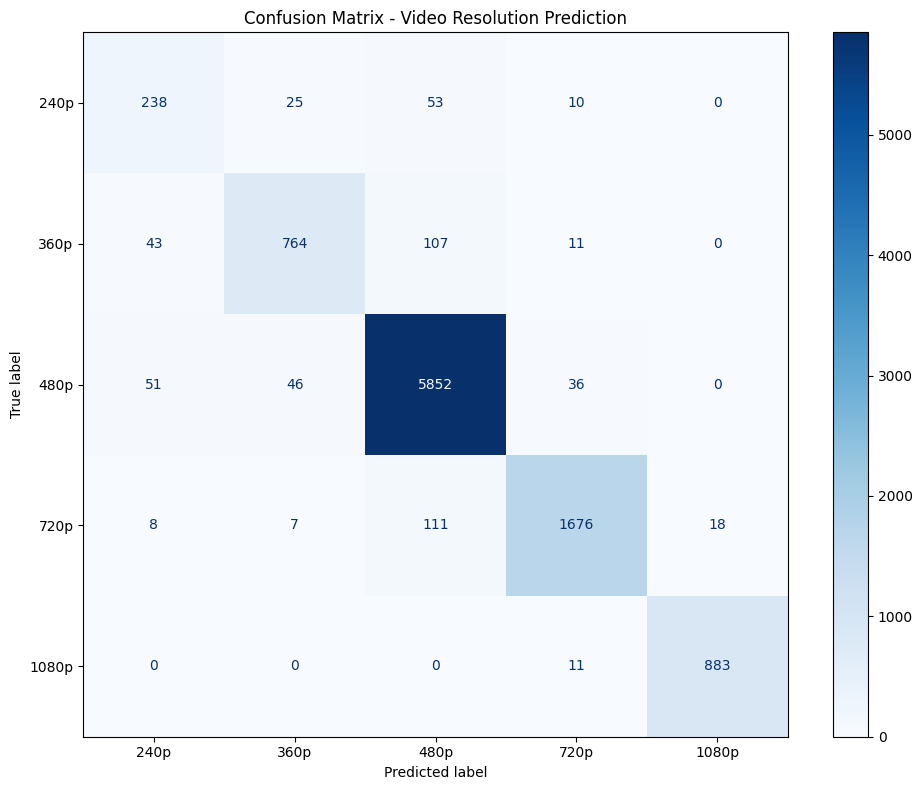


4. ROC/AUC Analysis:

ROC AUC Scores:
  Macro-average: 0.9926
  240p: 0.9867
  360p: 0.9891
  480p: 0.9928
  720p: 0.9946
  1080p: 0.9999

ROC curve saved to: roc_curve.png


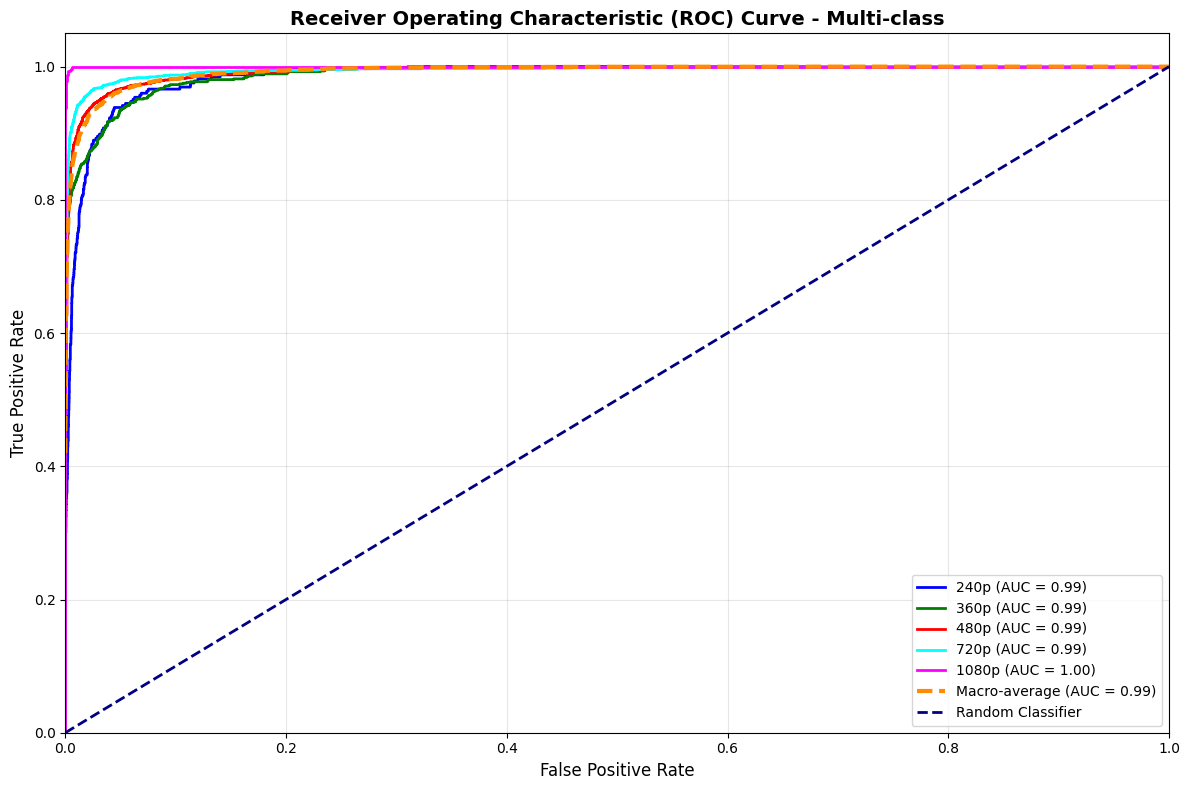


5. Prediction Distribution:
True distribution:
resolution
240.000      326
360.000      925
480.000     5985
720.000     1820
1080.000     894
Name: count, dtype: int64

Predicted distribution:
240.000      340
360.000      842
480.000     6123
720.000     1744
1080.000     901
Name: count, dtype: int64


In [69]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

print("MODEL EVALUATION")
print("=" * 80)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# 2. F1 Score (weighted average for multi-class)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n2. F1 Score (weighted): {f1:.4f}")

# Per-class F1 scores
print("\nPer-class metrics:")
print(classification_report(y_test, y_pred, target_names=['240p', '360p', '480p', '720p', '1080p']))

# 3. Confusion Matrix
print("\n3. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
print(cm)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['240p', '360p', '480p', '720p', '1080p']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Video Resolution Prediction')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\nConfusion matrix saved to: confusion_matrix.png")
plt.show()

# 4. ROC/AUC Curve (Multi-class using One-vs-Rest)
print("\n4. ROC/AUC Analysis:")

# Get probability predictions for ROC curve
y_prob = rf.predict_proba(X_test)

# Binarize the labels for multi-class ROC
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"\nROC AUC Scores:")
print(f"  Macro-average: {roc_auc['macro']:.4f}")
for i, res in enumerate(['240p', '360p', '480p', '720p', '1080p']):
    print(f"  {res}: {roc_auc[i]:.4f}")

# Plot ROC curves
plt.figure(figsize=(12, 8))

# Plot ROC curve for each class
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i, (color, res) in enumerate(zip(colors, ['240p', '360p', '480p', '720p', '1080p'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{res} (AUC = {roc_auc[i]:.2f})')

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=3, linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("\nROC curve saved to: roc_curve.png")
plt.show()

# 5. Additional insights
print("\n5. Prediction Distribution:")
print("True distribution:")
print(y_test.value_counts().sort_index())
print("\nPredicted distribution:")
print(pd.Series(y_pred).value_counts().sort_index())

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

Selected session: 127e85a6658ac3c2cad5e2022851e670
Duration: 470 seconds
Data points: 47
Resolutions present: [np.float64(360.0), np.float64(480.0)]

Plot saved to: resolution_prediction_timeline.png


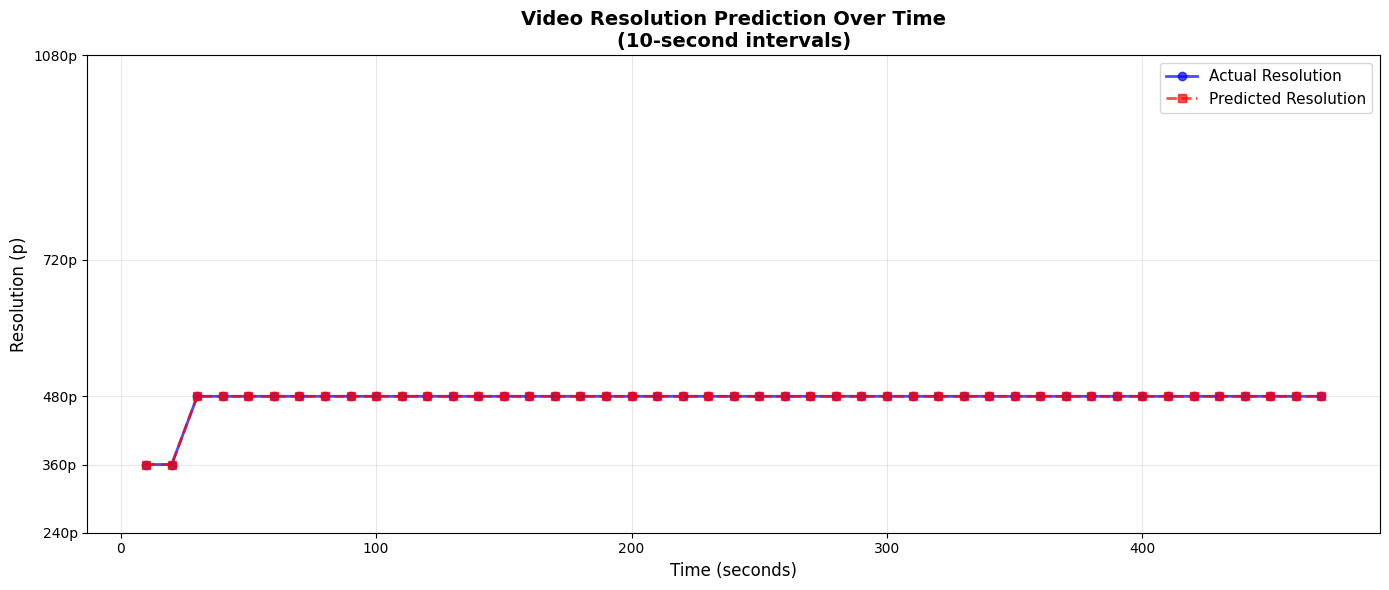


Session Prediction Accuracy: 100.00%
Correct predictions: 47/47


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Load original dataset with temporal information
nflx_full = pd.read_pickle('data/netflix_dataset.pkl')
nflx_full = nflx_full[nflx_full['resolution'].isin(VALID_RESOLUTIONS)]

# Find a session from our test set that has resolution changes
# We need to keep session_id and relative_timestamp for this part
test_indices = y_test.index

# Get sessions in test set
test_sessions = nflx_full.loc[test_indices, 'session_id'].unique()

# Pick a session with resolution changes
session_found = None
for sess_id in test_sessions[:50]:  # Check first 50 sessions
    sess_data = nflx_full[nflx_full['session_id'] == sess_id].sort_values('relative_timestamp')
    if sess_data['resolution'].nunique() > 1:  # Has resolution changes
        session_found = sess_id
        print(f"Selected session: {sess_id}")
        print(f"Duration: {sess_data['relative_timestamp'].max():.0f} seconds")
        print(f"Data points: {len(sess_data)}")
        print(f"Resolutions present: {sorted(sess_data['resolution'].unique())}")
        break

if session_found is None:
    # If no varying session found, just use the first one
    session_found = test_sessions[0]
    print(f"Using first available session: {session_found}")

# Get session data
session_data = nflx_full[nflx_full['session_id'] == session_found].sort_values('relative_timestamp')

# Extract features and actual resolutions
session_features = session_data.drop(columns=columns_to_drop + ['resolution'])
session_actual = session_data['resolution'].values
session_timestamps = session_data['relative_timestamp'].values

# Predict resolution at each 10-second interval
session_predictions = rf.predict(session_features)

# Plot results
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual resolution
ax.plot(session_timestamps, session_actual, 'o-', label='Actual Resolution', 
        linewidth=2, markersize=6, color='blue', alpha=0.7)

# Plot predicted resolution
ax.plot(session_timestamps, session_predictions, 's--', label='Predicted Resolution', 
        linewidth=2, markersize=6, color='red', alpha=0.7)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Resolution (p)', fontsize=12)
ax.set_title('Video Resolution Prediction Over Time\n(10-second intervals)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yticks([240, 360, 480, 720, 1080])
ax.set_yticklabels(['240p', '360p', '480p', '720p', '1080p'])

plt.tight_layout()
plt.savefig('resolution_prediction_timeline.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: resolution_prediction_timeline.png")
plt.show()

# Calculate accuracy for this session
session_accuracy = np.mean(session_predictions == session_actual)
print(f"\nSession Prediction Accuracy: {session_accuracy:.2%}")
print(f"Correct predictions: {np.sum(session_predictions == session_actual)}/{len(session_actual)}")

Randomly selected session: bb8d2862d8afc134eba9b1f835ab33e5
Duration: 590 seconds
Data points: 59
Resolutions present: [np.float64(480.0), np.float64(720.0), np.float64(1080.0)]

Plot saved to: resolution_prediction_random.png


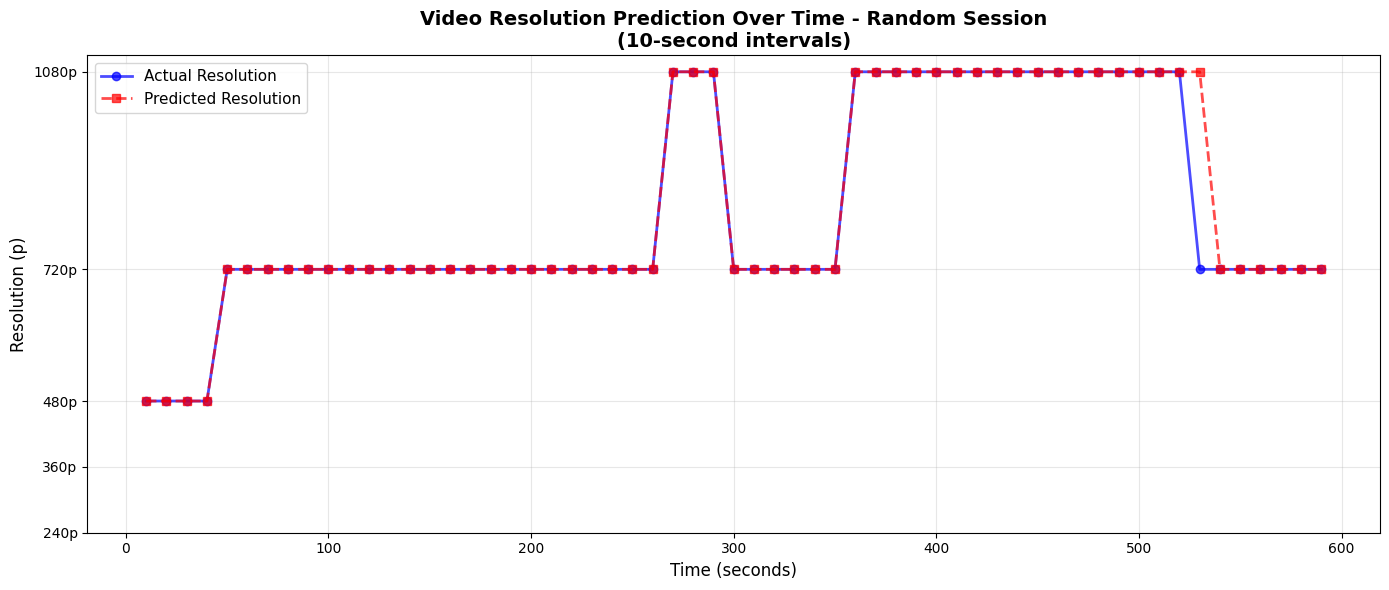


Session Prediction Accuracy: 98.31%
Correct predictions: 58/59

Prediction breakdown:
  480p: 4/4 correct (100.0%)
  720p: 34/35 correct (97.1%)
  1080p: 20/20 correct (100.0%)


In [80]:
# Alternative: Pick a random session from test set
import random

random.seed()  # For reproducibility (remove or change seed for different sessions)

# Get a random session from test set
random_session = random.choice(test_sessions)

print(f"Randomly selected session: {random_session}")

# Get session data
session_data = nflx_full[nflx_full['session_id'] == random_session].sort_values('relative_timestamp')

print(f"Duration: {session_data['relative_timestamp'].max():.0f} seconds")
print(f"Data points: {len(session_data)}")
print(f"Resolutions present: {sorted(session_data['resolution'].unique())}")

# Extract features and actual resolutions
session_features = session_data.drop(columns=columns_to_drop + ['resolution'])
session_actual = session_data['resolution'].values
session_timestamps = session_data['relative_timestamp'].values

# Predict resolution at each 10-second interval
session_predictions = rf.predict(session_features)

# Plot results
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual resolution
ax.plot(session_timestamps, session_actual, 'o-', label='Actual Resolution', 
        linewidth=2, markersize=6, color='blue', alpha=0.7)

# Plot predicted resolution
ax.plot(session_timestamps, session_predictions, 's--', label='Predicted Resolution', 
        linewidth=2, markersize=6, color='red', alpha=0.7)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Resolution (p)', fontsize=12)
ax.set_title(f'Video Resolution Prediction Over Time - Random Session\n(10-second intervals)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yticks([240, 360, 480, 720, 1080])
ax.set_yticklabels(['240p', '360p', '480p', '720p', '1080p'])

plt.tight_layout()
plt.savefig('resolution_prediction_random.png', dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: resolution_prediction_random.png")
plt.show()

# Calculate accuracy for this session
session_accuracy = np.mean(session_predictions == session_actual)
print(f"\nSession Prediction Accuracy: {session_accuracy:.2%}")
print(f"Correct predictions: {np.sum(session_predictions == session_actual)}/{len(session_actual)}")

# Show prediction details
print(f"\nPrediction breakdown:")
for res in sorted(session_data['resolution'].unique()):
    actual_count = np.sum(session_actual == res)
    predicted_count = np.sum((session_actual == res) & (session_predictions == res))
    print(f"  {int(res)}p: {predicted_count}/{actual_count} correct ({predicted_count/actual_count*100:.1f}%)")